In [51]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from itertools import product

from matplotlib import colors
import torch.nn.functional as F

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/viz'))
sys.path.append(os.path.join(os.getcwd(), '..'))

from symlie.model.networks.linear import CalculatedP, LinearP
from sympdee.sympde.viz.general_plots import imshows, plot_vals, simple_imshow, savefig, simple_imshow, imshow
from symlie.misc.utils_results import get_and_check_Ps, plot_seeds_and_Ps
from symlie.data.transforms import Transform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
map_kwargs = {
    'data_kwargs': {'grid_size': (1, 7), 'noise_std': 0.5},
    'transform_kwargs': {'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip': False},
    'data_dir': '../data/sine1d'
}

size = np.prod(map_kwargs['data_kwargs']['grid_size'])
features = size**2
set_bias = False

In [103]:
x = torch.randn(1, size)

def transform(x):
    return torch.roll(x, 1, 1)

Found run_id xxidyaps


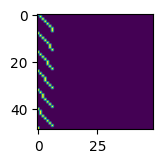

In [30]:
P = get_and_check_Ps([1], map_kwargs, use_P_from_noise = True)[0]
P = 'space_translation'
# P = 'none'

linear = LinearP(in_features=size, out_features=size, bias = set_bias, P_init = P)
linear_none = LinearP(in_features=size, out_features=size, bias = set_bias, P_init = 'none')
linear_none.weight = linear.weight

imshow(linear.P, l = 0.5)

In [31]:
def plot(out, title = None):
    plt.figure(figsize=(5, 3))
    plt.plot(out.T, 'o-')
    plt.title(title)
    plt.show()

def plot2(x_a, x_b, title = None):
    plt.figure(figsize=(5, 1.))
    plt.plot(x_a.T, 'o--', alpha = 0.5)
    plt.plot(x_b.T, 'o:', alpha = 0.5)
    plt.title(title)
    plt.show()

In [32]:
x_a = x
out_a = linear(x_a).detach()
out_a_prime = transform(out_a)

out_a_tilde = linear_none(x_a).detach()
out_a_prime_tilde = transform(out_a_tilde)

x_b = x
x_b_prime = transform(x_b)
out_b_prime = linear(x_b_prime).detach()

out_b_prime_tilde = linear_none(x_b_prime).detach()

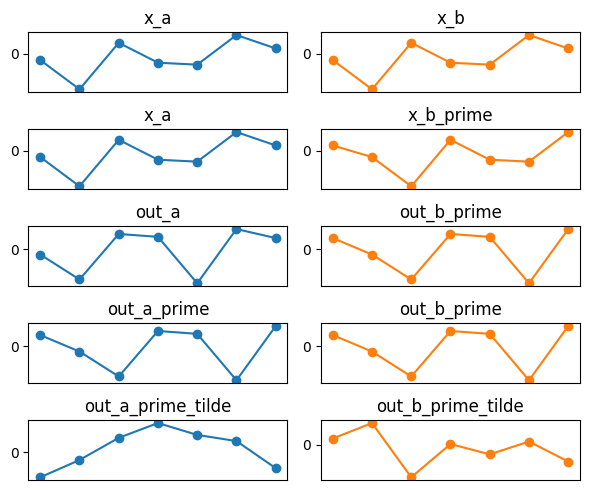

In [76]:
x_plots = [
    [x_a, x_b],
    [x_a, x_b_prime],
    [out_a, out_b_prime],
    [out_a_prime, out_b_prime],
    [out_a_prime_tilde, out_b_prime_tilde]
]

x_titles = [
    ['x_a', 'x_b'],
    ['x_a', 'x_b_prime'],
    ['out_a', 'out_b_prime'],
    ['out_a_prime', 'out_b_prime'],
    ['out_a_prime_tilde', 'out_b_prime_tilde']
]

nrows = len(x_plots)

fig, axs = plt.subplots(nrows, 2, figsize = (6, 1.*nrows), tight_layout = True)
for i, (x_l, x_r) in enumerate(x_plots):
    axs[i, 0].plot(x_l.T, 'o-', color = 'tab:blue')
    axs[i, 0].set_title(x_titles[i][0])

    axs[i, 1].plot(x_r.T, 'o-', color = 'tab:orange')
    axs[i, 1].set_title(x_titles[i][1])
    for ax in axs[i]:
        ax.set_xticks([])
        ax.set_yticks([0])
        # ax.axis('off')
plt.show()
plt.close()

In [84]:
F.cosine_similarity(out_a_prime_tilde, out_a_prime, dim = 1)

tensor([-0.2657])

In [74]:
F.kl_div(out_a_prime, out_a_prime_tilde, reduction='none')

tensor([[    nan,     nan,  3.0082, -1.5621, -1.2167,  2.4311,     nan]])

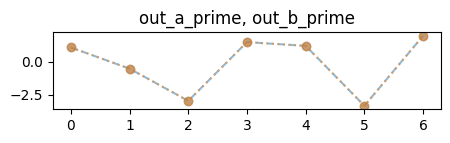

In [34]:
plot2(out_a_prime, out_b_prime, 'out_a_prime, out_b_prime')

In [35]:
e_g = torch.linalg.pinv(x_a) @ x_b_prime
assert torch.allclose(x_a @ e_g, x_b_prime)

e_o = torch.linalg.pinv(out_a_prime) @ out_b_prime
assert torch.allclose(out_a_prime @ e_o, out_b_prime)

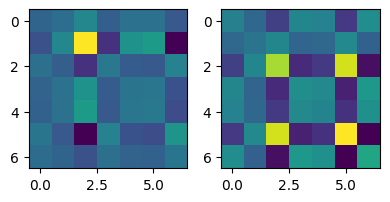

In [36]:
imshows([e_g, e_o])

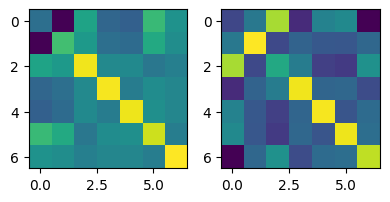

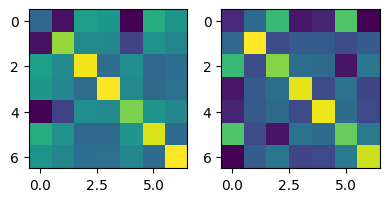

In [37]:
def decompose_matrix(M, return_dict: bool = False):
    U, S, V = torch.linalg.svd(M)

    if return_dict:
        return dict(U=U, S=S, V=V)
    return U, S, V

x_a_svd = decompose_matrix(x_a, return_dict=True)
x_b_prime_svd = decompose_matrix(x_b_prime, return_dict=True)
out_a_svd = decompose_matrix(out_a, return_dict=True)
out_b_prime_svd = decompose_matrix(out_b_prime, return_dict=True)

imshows([x_a_svd['V'], x_b_prime_svd['V']])
imshows([out_a_svd['V'], out_b_prime_svd['V']])

In [38]:
torch.linalg.inv(x_a_svd['V']) @ x_b_prime_svd['V']

tensor([[ 0.1446, -0.8353,  0.0310, -0.1425, -0.3016,  0.3471,  0.2205],
        [ 0.3251,  0.2982, -0.6376,  0.0985, -0.3792,  0.0363,  0.4940],
        [ 0.7435,  0.1002,  0.5887,  0.1510, -0.0411, -0.1984,  0.1631],
        [-0.1929, -0.1441,  0.0342,  0.9659, -0.0466,  0.0710,  0.0246],
        [ 0.2606, -0.2394, -0.3127,  0.0649,  0.8526, -0.0242,  0.2128],
        [ 0.1556,  0.3202,  0.0977,  0.0186,  0.1364,  0.9091, -0.1355],
        [-0.4373,  0.1508,  0.3706, -0.0980,  0.1258,  0.0821,  0.7852]])

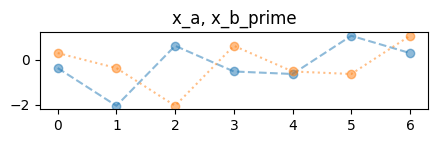

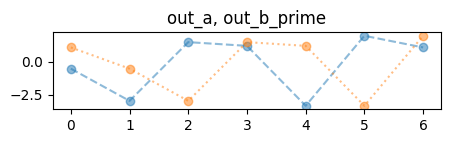

In [39]:
plot2(x_a, x_b_prime, 'x_a, x_b_prime')
plot2(out_a, out_b_prime, 'out_a, out_b_prime')

# plot2(transform(x_a), x_b_prime, 'transform(x_a), x_b_prime')
# plot2(transform(out_a), out_b_prime, 'transform(out_a), out_b_prime')

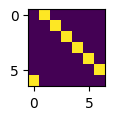

In [40]:
eye_shift = torch.roll(torch.eye(size), 1, 1)
imshow(eye_shift, figsize=(1,1))

assert torch.allclose(x_a @ eye_shift, x_b_prime)
assert torch.allclose(out_a @ eye_shift, out_b_prime)

In [41]:
x_a

tensor([[-0.3736, -2.0433,  0.6125, -0.5249, -0.6362,  1.0556,  0.2898]])

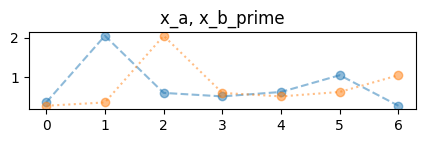

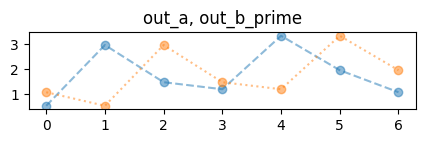

In [42]:
plot2(torch.abs(x_a), torch.abs(x_b_prime), 'x_a, x_b_prime')
plot2(torch.abs(out_a), torch.abs(out_b_prime), 'out_a, out_b_prime')

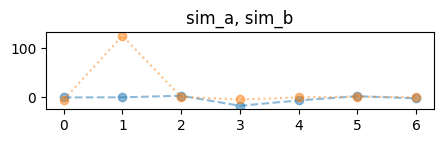

In [94]:
def similarity(a, b):
    # return F.cosine_similarity(a, b, dim = 1)
    return F.kl_div(torch.exp(a), torch.exp(b), reduction='none')

sim_a = similarity(out_a_prime, out_a_prime_tilde)
sim_b = similarity(out_b_prime, out_b_prime_tilde)

plot2(sim_a, sim_b, 'sim_a, sim_b')

In [88]:
similarity(x_a, x_b_prime), similarity(out_a, out_b_prime)

(tensor([-0.1446]), tensor([-0.3480]))

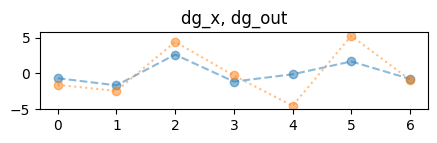

In [61]:
def dg(a, b):
    # return torch.abs(a) / torch.abs(b)
    # return (a - b) / (a + b)
    # return (b-a)/a
    # return (torch.linalg.pinv(a) * b).reshape(1, -1)
    # return a * b
    # return a.T * b
    return a - b

dg_x = dg(x_a, x_b_prime)
dg_out = dg(out_a, out_b_prime)

plot2(dg_x, dg_out, 'dg_x, dg_out')
# imshows([dg_x, dg_out], titles = ['dg_x', 'dg_out'])

In [57]:
F.log_softmax(dg_x, dim=0)

tensor([[-2.0224, -1.9581, -3.5506, -2.1808, -2.0024, -2.0500, -2.4972],
        [-2.5062, -1.3343, -0.1389, -3.2034, -1.1260, -0.9878, -4.2597],
        [-1.7366, -2.3265, -5.5654, -1.5768, -2.5200, -2.6773, -1.4563],
        [-2.0662, -1.9016, -3.2415, -2.2734, -1.9230, -1.9538, -2.6569],
        [-2.0984, -1.8600, -3.0141, -2.3415, -1.8646, -1.8830, -2.7743],
        [-1.6082, -2.4921, -6.4708, -1.3054, -2.7525, -2.9592, -0.9886],
        [-1.8301, -2.2060, -4.9061, -1.7744, -2.3506, -2.4720, -1.7969]])

In [60]:
dg_out.flatten()

tensor([-0.5721,  0.2827,  1.5800, -0.7860, -0.6360,  1.7777, -1.0419, -3.1974,
         1.5800,  8.8302, -4.3925, -3.5543,  9.9352, -5.8231,  1.5905, -0.7860,
        -4.3925,  2.1850,  1.7681, -4.9422,  2.8966,  1.2870, -0.6360, -3.5543,
         1.7681,  1.4307, -3.9991,  2.3439, -3.5975,  1.7777,  9.9352, -4.9422,
        -3.9991, 11.1785, -6.5518,  2.1085, -1.0419, -5.8231,  2.8966,  2.3439,
        -6.5518,  3.8400,  1.1578, -0.5721, -3.1974,  1.5905,  1.2870, -3.5975,
         2.1085])

In [59]:
F.kl_div(dg_x.flatten(), dg_out.flatten(), reduction='none')

tensor([     nan,  -0.3966,  -0.4835,      nan,      nan,   0.6003,      nan,
             nan,  -0.4835, -17.6329,      nan,      nan,   9.8978,      nan,
          0.4558,      nan,      nan,   0.8882,   1.5760,      nan,   1.2080,
          0.5205,      nan,      nan,   1.5760,   0.1183,      nan,   3.2952,
             nan,   0.6003,   9.8978,      nan,      nan,  22.4610,      nan,
          0.9280,      nan,      nan,   1.2080,   3.2952,      nan,   0.8880,
          0.0724,      nan,      nan,   0.4558,   0.5205,      nan,   0.9280])

In [49]:
x_a.T @ x_b_prime


tensor([[-0.1083,  0.1396,  0.7634, -0.2288,  0.1961,  0.2377, -0.3944],
        [-0.5921,  0.7634,  4.1751, -1.2515,  1.0725,  1.2999, -2.1568],
        [ 0.1775, -0.2288, -1.2515,  0.3751, -0.3215, -0.3896,  0.6465],
        [-0.1521,  0.1961,  1.0725, -0.3215,  0.2755,  0.3339, -0.5540],
        [-0.1843,  0.2377,  1.2999, -0.3896,  0.3339,  0.4047, -0.6715],
        [ 0.3059, -0.3944, -2.1568,  0.6465, -0.5540, -0.6715,  1.1142],
        [ 0.0840, -0.1083, -0.5921,  0.1775, -0.1521, -0.1843,  0.3059]])

In [48]:
x_a.T * x_b_prime

tensor([[-0.1083,  0.1396,  0.7634, -0.2288,  0.1961,  0.2377, -0.3944],
        [-0.5921,  0.7634,  4.1751, -1.2515,  1.0725,  1.2999, -2.1568],
        [ 0.1775, -0.2288, -1.2515,  0.3751, -0.3215, -0.3896,  0.6465],
        [-0.1521,  0.1961,  1.0725, -0.3215,  0.2755,  0.3339, -0.5540],
        [-0.1843,  0.2377,  1.2999, -0.3896,  0.3339,  0.4047, -0.6715],
        [ 0.3059, -0.3944, -2.1568,  0.6465, -0.5540, -0.6715,  1.1142],
        [ 0.0840, -0.1083, -0.5921,  0.1775, -0.1521, -0.1843,  0.3059]])